# Complex t-distribution

**1st case**: CCRB

In [23]:
# Libraries
from scipy.linalg import null_space
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Parameters
lambda_real = 3
eta_real = 1
N = 16
M = 3*N

In [25]:
# Data
np.random.seed(4320)
X_real = t.rvs(df=lambda_real, scale=eta_real, size=(M, N), random_state=4320)
X_imag = t.rvs(df=lambda_real, scale=eta_real, size=(M, N), random_state=4320)
X = (X_real + 1j * X_imag) / np.sqrt(2)   # normalization so var = η·λ/(λ-2)
print("Size of the matrix",X.shape)
print("We have", N*M, "idependent samples from a t-distribution")

Size of the matrix (48, 16)
We have 768 idependent samples from a t-distribution


**Building estimators**


In [26]:
# Method of moments for λ and η
mu_hat = X.mean()
m2_hat = np.mean(np.abs(X - mu_hat)**2)
m4_hat = np.mean(np.abs(X - mu_hat)**4)

lambda_estimate = 2* ((m4_hat / m2_hat **2) - 1 ) / ((m4_hat / m2_hat **2) - 2 )
eta_estimate = lambda_estimate / (m2_hat * (lambda_estimate - 1))
print("Method of moments estimator for λ:", lambda_estimate)
print("Method of moments estimator for η:", eta_estimate)



Method of moments estimator for λ: 2.225383413707034
Method of moments estimator for η: 0.683876957105414


Quite a big difference between estimated and actual values: the method of moments is suboptimal.

In [27]:
# Iterative method for Σ (Constrained Maximum Likelihood
def estimate_sigma_cml(X, lambda_estimate, eta_estimate, tol=1e-6, max_iter=200):
    sigma = np.eye(N, dtype=np.complex128)

    for i in range(max_iter):
        sigma_inv = np.linalg.inv(sigma)
        S = np.zeros((N, N), dtype=np.complex128)
        for x in X:
            quad_form = np.conjugate(x) @ sigma_inv @ x
            denom = quad_form + lambda_estimate / eta_estimate
            S += np.outer(x, np.conjugate(x)) / denom

        sigma_next = (N / np.trace(S)) * S

        sigma_next = 0.5 * (sigma_next + sigma_next.conj().T)

        rel_diff = np.linalg.norm(sigma_next - sigma, 'fro') / np.linalg.norm(sigma, 'fro')
        if rel_diff < tol:
            return sigma_next
        sigma = sigma_next
    return sigma

sigma_estimate = estimate_sigma_cml(X,lambda_estimate,eta_estimate)

In [28]:
# Compute information matrix

def compute_U_CCRB():
    l = int((N * (N + 1)) / 2)
    diag_indices = [int(i*(i+1)/2 + i) for i in range(N)]
    grad_f = np.zeros((l + 2, 1))
    for idx in diag_indices:
        grad_f[idx, 0] = 1
    U = null_space(grad_f.T)  # (l+2, l+1) matrix

    return U
U = compute_U_CCRB()

def duplication_matrix():
    l = int(N * (N + 1) / 2)
    D = np.zeros((N * N, l)) # size of D is (N^2, l)

    index_map = {}
    count = 0
    for i in range(N):
        for j in range(i + 1):
            index_map[(i, j)] = count
            count += 1
    for (i, j), col in index_map.items():
        E = np.zeros((N, N))
        E[i, j] = 1
        if i != j:
            E[j, i] = 1
        D[:, col] = E.flatten(order='F')
    return D
D = duplication_matrix()

def compute_F_theta(sigma_estimate, lambda_real, eta_real):
    sigma_estimate_inv = np.linalg.inv(sigma_estimate)
    vec_sigma_inv = sigma_estimate_inv.flatten(order='F').reshape(-1, 1)  # of size (N^2, 1)
    # F_sigma
    F_sigma = (-1.0 / (N + lambda_real + 1)) * (vec_sigma_inv @ vec_sigma_inv.T) + ((N + lambda_real) / (N + lambda_real + 1)) * np.kron(sigma_estimate_inv, sigma_estimate_inv)

    # F_c
    F_c_1 = (-1.0 / ((N + lambda_real) * (N + lambda_real + 1))) * vec_sigma_inv
    F_c_2 = (-lambda_real / (eta_real * (N + lambda_real + 1))) * vec_sigma_inv
    F_c = np.hstack([F_c_1, F_c_2])  # size of F_c is (N^2, 2)

    # F_lambda_eta
    sum_k = sum([1.0 / (lambda_real + k)**2 for k in range(N)])
    F_lambda_eta = np.array([
        [
            sum_k + ((lambda_real + 1) * (N + lambda_real)) / (lambda_real * (N + lambda_real + 1)) - (2 * N) / (lambda_real * (lambda_real + N)) - 1,
            lambda_real * N / (eta_real * lambda_real * (N + lambda_real) * (N + lambda_real + 1))
        ],
        [
            lambda_real * N / (eta_real * lambda_real * (N + lambda_real) * (N + lambda_real + 1)),
            lambda_real * N / (eta_real**2 * (N + lambda_real + 1))
        ]
    ])

    # F
    F = np.block([
        [F_sigma, F_c],
        [F_c.T, F_lambda_eta]
    ])

    # T2
    T2 = np.block([
        [D, np.zeros((D.shape[0], 2))],
        [np.zeros((2, D.shape[1])), np.eye(2)]
    ])

    # Fisher information matrix
    F_theta = T2.T @ F @ T2
    return F_theta
F = compute_F_theta(sigma_estimate,lambda_real,eta_real)


In [29]:
# Compute CCRB
def compute_CCRB(sigma_estimate,lambda_real,eta_real):
    U = compute_U_CCRB()
    F = compute_F_theta(sigma_estimate,lambda_real,eta_real)
    F_proj = U.T @ F @ U
    CCRB = U @ np.linalg.inv(F_proj) @ U.T
    return CCRB

CCRB = compute_CCRB(sigma_estimate,lambda_real,eta_real)
print(f"‖CCRB‖_F = {np.linalg.norm(CCRB, 'fro'):.3f}")


‖CCRB‖_F = 25.100


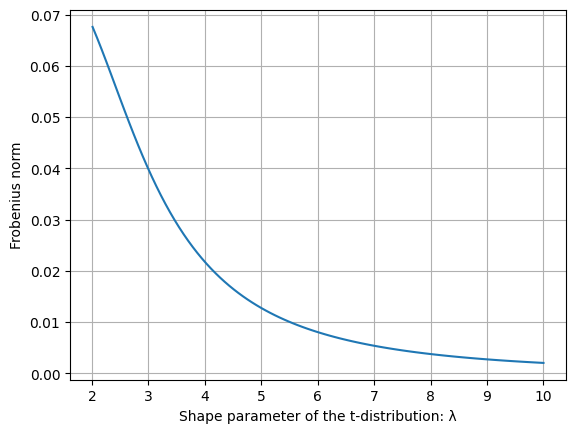

In [30]:
# Visualization
CCRB_norms = []
lambdas = np.linspace(2.01, 10, 100)
for l in lambdas:
    CCRB = compute_CCRB(sigma_estimate,l,eta_real)
    norm = np.linalg.norm(CCRB,'fro')
    CCRB_norms.append(1/norm)

plt.plot(lambdas, CCRB_norms)
plt.xlabel("Shape parameter of the t-distribution: λ")
plt.ylabel("Frobenius norm")
plt.grid(True)
plt.show()

**2nd case:** MCRB

**Building estimators**


In [10]:
sigma_0 = lambda_real / (eta_real * (lambda_real - 1))
def estimate_sigma_cmml(X):
    X = X.T
    sum_xxH = np.zeros((N, N), dtype=np.complex128)
    sum_norms = 0.0
    for m in range(M):
        x_m = X[:, m].reshape(-1, 1)
        sum_xxH += x_m @ x_m.conj().T
        sum_norms += (x_m.conj().T @ x_m).item()

    sigma_cmml = (N / sum_norms) * sum_xxH
    return sigma_cmml

sigma_cmml = estimate_sigma_cmml(X)

In [11]:
# Calculus for the MCRB
def compute_A_theta(sigma_cmml):
    sigma_cmml_inv = np.linalg.inv(sigma_cmml)
    vec_sigma_cmml_inv = sigma_cmml_inv.flatten(order='F').reshape(-1, 1)

    # Compute A
    A_sigma_cmml = -np.kron(sigma_cmml_inv, sigma_cmml_inv)
    A_sigma2 = -N / sigma_0**4
    A_c = -1 / sigma_0**2 * vec_sigma_cmml_inv

    A_full = np.block([
        [A_sigma_cmml, A_c],
        [A_c.T, np.array([[A_sigma2]])]
    ])

    T1 = np.block([
        [D,                        np.zeros((N*N, 1))],
        [np.zeros((1, D.shape[1])),       np.ones((1, 1))]
    ])

    # Projection of A on the space (vecs(Σ), σ²)
    A= T1.T @ A_full @ T1
    return A
A = compute_A_theta(sigma_cmml)

def compute_B_theta(sigma_cmml, lambda_real):
    sigma_cmml_inv = np.linalg.inv(sigma_cmml)
    vec_sigma_cmml_inv = sigma_cmml_inv.flatten(order='F').reshape(-1, 1)
    # Compute B
    B_Sigma = (1 / (lambda_real - 2)) * (vec_sigma_cmml_inv @ vec_sigma_cmml_inv.T) + ((lambda_real - 1) / (lambda_real - 2)) * np.kron(sigma_cmml_inv, sigma_cmml_inv)
    B_sigma0 = (N * (N + lambda_real - 1)) / (sigma_0**4 * (lambda_real - 2))
    B_c = ((N + lambda_real - 1) / (sigma_0 * (lambda_real - 2))) * vec_sigma_cmml_inv.T

    B_full = np.block([
        [B_Sigma, B_c.T],
        [B_c, np.array([[B_sigma0]])]
    ])

    T1 = np.block([
        [D,                        np.zeros((N*N, 1))],
        [np.zeros((1, D.shape[1])),       np.ones((1, 1))]
    ])
    # Projection of B on the space (vecs(Σ), σ²)
    B = T1.T @ B_full @ T1
    return B
B = compute_B_theta(sigma_cmml,lambda_real)

def compute_U_MCRB():
    l = int(N * (N + 1) / 2)
    diag_indices = [int(i*(i+1)/2 + i) for i in range(N)]
    grad_f = np.zeros((l + 1, 1))
    for idx in diag_indices:
        grad_f[idx, 0] = 1
    grad_f[-1, 0] = 0

    U = null_space(grad_f.T)
    return U
U = compute_U_MCRB()

In [12]:
# Compute MCRB
def compute_MCRB(sigma_cmml,lambda_real):
    A = compute_A_theta(sigma_cmml)
    B = compute_B_theta(sigma_cmml,lambda_real)
    A_proj = U.T @ A @ U
    B_proj = U.T @ B @ U
    MCRB = 1/ M * U @ np.linalg.inv(A_proj) @ B_proj @ np.linalg.inv(A_proj) @ U.T
    return MCRB

MCRB = compute_MCRB(sigma_cmml,lambda_real)
print(f"‖MCRB‖_F = {np.linalg.norm(MCRB, 'fro'):.3f}")


‖MCRB‖_F = 0.574


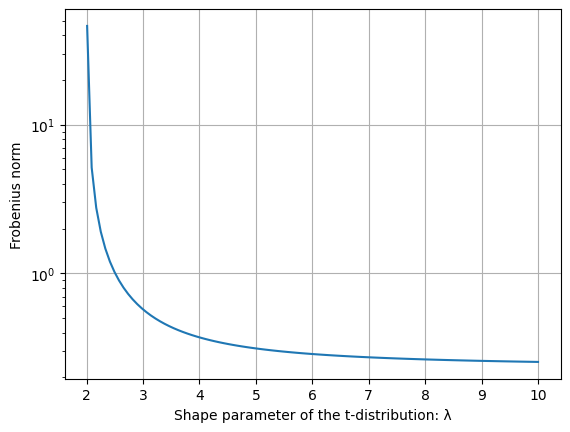

In [13]:
# Visualization
MCRB_norms = []
lambdas = np.linspace(2.01, 10, 100)
for l in lambdas:
    MCRB = compute_MCRB(sigma_cmml,l)
    norm = np.linalg.norm(MCRB,'fro')
    MCRB_norms.append(norm)

plt.plot(lambdas, MCRB_norms)
plt.xlabel("Shape parameter of the t-distribution: λ")
plt.ylabel("Frobenius norm")
plt.yscale("log")
plt.grid(True)
plt.show()

**Comparison**



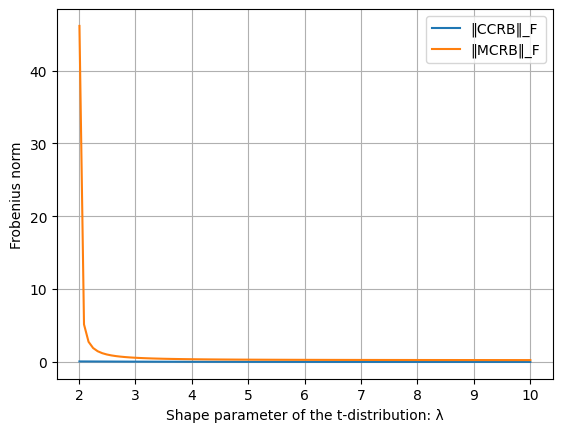

In [14]:
# Visualization
plt.plot(lambdas, CCRB_norms, label='‖CCRB‖_F')
plt.plot(lambdas, MCRB_norms, label='‖MCRB‖_F')
plt.xlabel("Shape parameter of the t-distribution: λ")
plt.ylabel("Frobenius norm")
plt.grid(True)
plt.legend()
plt.show()


# AR(1)

In [1]:
# Libraries
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#np.random.seed(4320)
N = 1000

In [3]:
# Parameters
theta = 0.5
sigma = 1
v = 3

In [4]:
def generate_Normal(theta,N, sigma):
    X_Normal = [np.random.normal(0, 1)]
    epsilon = np.random.normal(0, sigma, size=N)
    for e in epsilon:
        X_Normal.append(theta*X_Normal[-1] + e)
    return np.array(X_Normal), epsilon

X_Normal = generate_Normal(theta,N, sigma)[0]
epsilon_normal = generate_Normal(theta,N, sigma)[1]

In [5]:
def generate_Student(theta,N, sigma, v):
    X_Student = [np.random.normal(0, 1)]
    epsilon = sigma * t.rvs(df=v, size=N)
    for e in epsilon:
        X_Student.append(theta*X_Student[-1] + e)
    return np.array(X_Student), epsilon

X_Student = generate_Student(theta,N, sigma, v)[0]
epsilon_student = generate_Student(theta,N, sigma, v)[1]

In [6]:
# Our data:
print("Mean of X_Normal:",np.mean(X_Normal))
print("Mean of epsilon_normal:",np.mean(epsilon_normal))
print("Mean of X_Student:",np.mean(X_Student))
print("Mean of epsilon_student:",np.mean(epsilon_student))

Mean of X_Normal: 0.010563525956514367
Mean of epsilon_normal: -0.02647100418736906
Mean of X_Student: 0.13549475350809706
Mean of epsilon_student: -0.019012534533059237


**1st case:** t-distribution misspecified as Gaussian

In [7]:
# Estimation of A
def estimate_A_theta(theta,N,sigma,v):
    term1 = (1 - theta**(2*N)) / (1 - theta**2)
    term2 = v * sigma**2 / (v - 2) * (1 / (1 - theta**2)) * (N - (1 - theta**(2*N)) / (1 - theta**2))
    return - (1 / sigma**2) * (term1 + term2)

print("Estimation of A :", estimate_A_theta(theta,N,sigma,v))

Estimation of A : -3996.0


In [8]:
# Estimation of B (Monte-Carlo method)
def estimate_B_theta(theta, N, sigma, v, M=10000):
    E = 0
    for _ in range(M):
        X_n, eps = generate_Student(theta, N, sigma, v)
        theta_power = np.power(theta*np.ones(N),np.arange(N))
        S1 = np.sum(theta_power*X_n[0]*eps)
        S2 = np.sum(np.cumsum(theta_power*eps)*eps)
        E += (S1+S2)**2
    return (1 / sigma**4) * E / M

print("Estimation of B :", estimate_B_theta(theta,N,sigma,v))

Estimation of B : 10123.023493293098


In [9]:
# Compute the MCRB
def compute_MCRB(v,theta,N):
    A_theta = estimate_A_theta(theta,N,sigma,v)
    B_theta = estimate_B_theta(theta,N,sigma,v)
    print(v,end=" ")
    return (B_theta / A_theta**2) / N

print("MCRB :", compute_MCRB(v,theta,N))

3 MCRB : 9.925118847643186e-07


2.01 2.0907070707070705 2.1714141414141412 2.252121212121212 2.3328282828282827 2.4135353535353534 2.494242424242424 2.574949494949495 2.6556565656565656 2.7363636363636363 2.817070707070707 2.897777777777778 2.9784848484848485 3.0591919191919192 3.13989898989899 3.2206060606060607 3.3013131313131314 3.382020202020202 3.462727272727273 3.5434343434343436 3.6241414141414143 3.704848484848485 3.785555555555556 3.8662626262626265 3.946969696969697 4.027676767676768 4.108383838383839 4.189090909090909 4.26979797979798 4.350505050505051 4.431212121212122 4.511919191919192 4.592626262626263 4.673333333333334 4.7540404040404045 4.834747474747475 4.915454545454546 4.996161616161617 5.076868686868687 5.157575757575758 5.238282828282829 5.3189898989899 5.39969696969697 5.480404040404041 5.561111111111112 5.6418181818181825 5.722525252525253 5.803232323232324 5.883939393939394 5.9646464646464645 6.045353535353535 6.126060606060606 6.206767676767677 6.287474747474747 6.368181818181818 6.4488888888

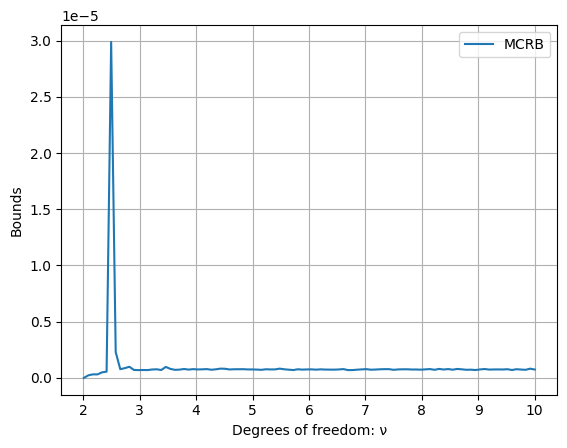

In [24]:
# Visualization
list_v = np.linspace(2.01, 10, 100)
list_MCRB = [compute_MCRB(v,theta,N) for v in list_v]
plt.plot(list_v, list_MCRB,label="MCRB")
plt.legend()
plt.xlabel("Degrees of freedom: ν")
plt.ylabel("Bounds")
plt.grid(True)
plt.show()

**2nd case:** t-distribution correctly specified

In [10]:
# Estimation of the information matrix (Monte-Carlo method)
def estimate_expectation(theta,N,sigma,v,M=10000):
    E = 0
    for _ in range(M):
        X_n, eps = generate_Student(theta, N, sigma, v)
        theta_power = np.power(theta*np.ones(N),np.arange(N))
        F = (eps**2 - v * sigma**2) / ((v * sigma**2 + eps**2)**2)
        S = np.sum((theta_power*X_n[0] + np.cumsum(theta_power*eps))**2 * F)
        E += S
    return (v+1) * E / M

print("Expectation estimation :", estimate_expectation(theta,N,sigma,v))

Expectation estimation : -2996.909048242864


In [14]:
# Compute the CRB
def compute_CRB(v,theta,N):
    return -1/(N*(estimate_expectation(theta,N,sigma,v)))

print("CRB :", compute_CRB(v,theta,N))

CRB : 3.7629390059490126e-07


2.01 2.0907070707070705 2.1714141414141412 2.252121212121212 2.3328282828282827 2.4135353535353534 2.494242424242424 2.574949494949495 2.6556565656565656 2.7363636363636363 2.817070707070707 2.897777777777778 2.9784848484848485 3.0591919191919192 3.13989898989899 3.2206060606060607 3.3013131313131314 3.382020202020202 3.462727272727273 3.5434343434343436 3.6241414141414143 3.704848484848485 3.785555555555556 3.8662626262626265 3.946969696969697 4.027676767676768 4.108383838383839 4.189090909090909 4.26979797979798 4.350505050505051 4.431212121212122 4.511919191919192 4.592626262626263 4.673333333333334 4.7540404040404045 4.834747474747475 4.915454545454546 4.996161616161617 5.076868686868687 5.157575757575758 5.238282828282829 5.3189898989899 5.39969696969697 5.480404040404041 5.561111111111112 5.6418181818181825 5.722525252525253 5.803232323232324 5.883939393939394 5.9646464646464645 6.045353535353535 6.126060606060606 6.206767676767677 6.287474747474747 6.368181818181818 6.4488888888

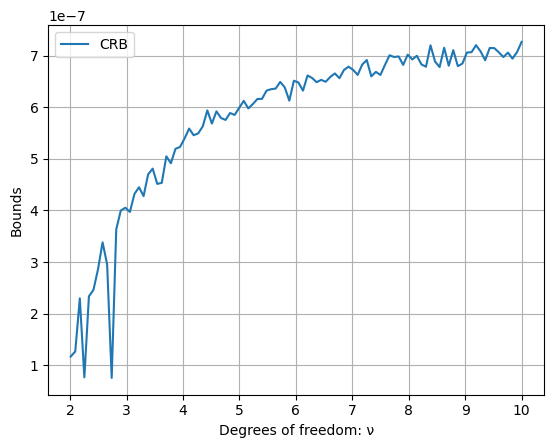

In [27]:
# Visualization
list_v = np.linspace(2.01, 10, 100)
list_CRB = [compute_CRB(v,theta,N) for v in list_v]
plt.plot(list_v, list_CRB,label="CRB")
plt.legend()
plt.xlabel("Degrees of freedom: ν")
plt.ylabel("Bounds")
plt.grid(True)
plt.show()

**Comparison**

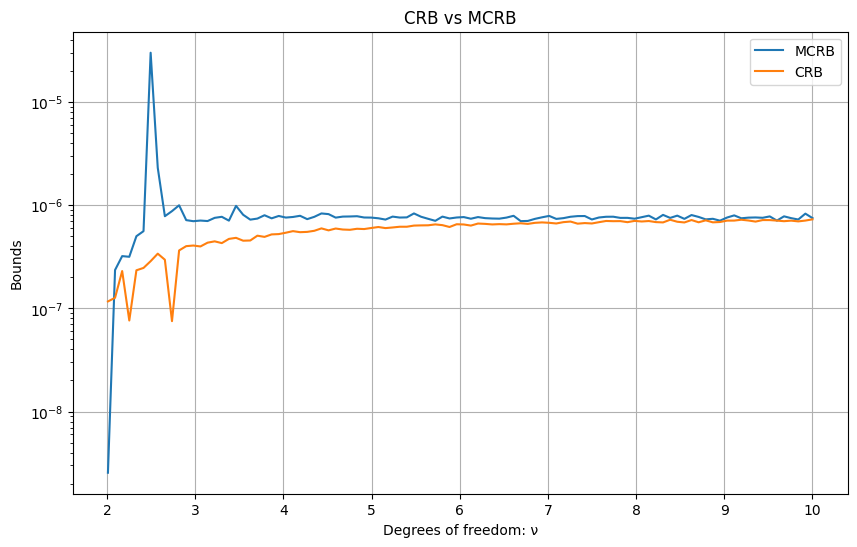

In [28]:
# Visualization
list_v = np.linspace(2.01, 10, 100)
plt.figure(figsize=(10, 6))
plt.plot(list_v, list_MCRB, label="MCRB")
plt.plot(list_v, list_CRB, label="CRB")
plt.xlabel("Degrees of freedom: ν")
plt.ylabel("Bounds")
plt.yscale("log")
plt.title("CRB vs MCRB")
plt.legend()
plt.grid(True)
plt.show()

**Visualization for many values of N**

2.01 2.0907070707070705 2.1714141414141412 2.252121212121212 2.3328282828282827 2.4135353535353534 2.494242424242424 2.574949494949495 2.6556565656565656 2.7363636363636363 2.817070707070707 2.897777777777778 2.9784848484848485 3.0591919191919192 3.13989898989899 3.2206060606060607 3.3013131313131314 3.382020202020202 3.462727272727273 3.5434343434343436 3.6241414141414143 3.704848484848485 3.785555555555556 3.8662626262626265 3.946969696969697 4.027676767676768 4.108383838383839 4.189090909090909 4.26979797979798 4.350505050505051 4.431212121212122 4.511919191919192 4.592626262626263 4.673333333333334 4.7540404040404045 4.834747474747475 4.915454545454546 4.996161616161617 5.076868686868687 5.157575757575758 5.238282828282829 5.3189898989899 5.39969696969697 5.480404040404041 5.561111111111112 5.6418181818181825 5.722525252525253 5.803232323232324 5.883939393939394 5.9646464646464645 6.045353535353535 6.126060606060606 6.206767676767677 6.287474747474747 6.368181818181818 6.4488888888

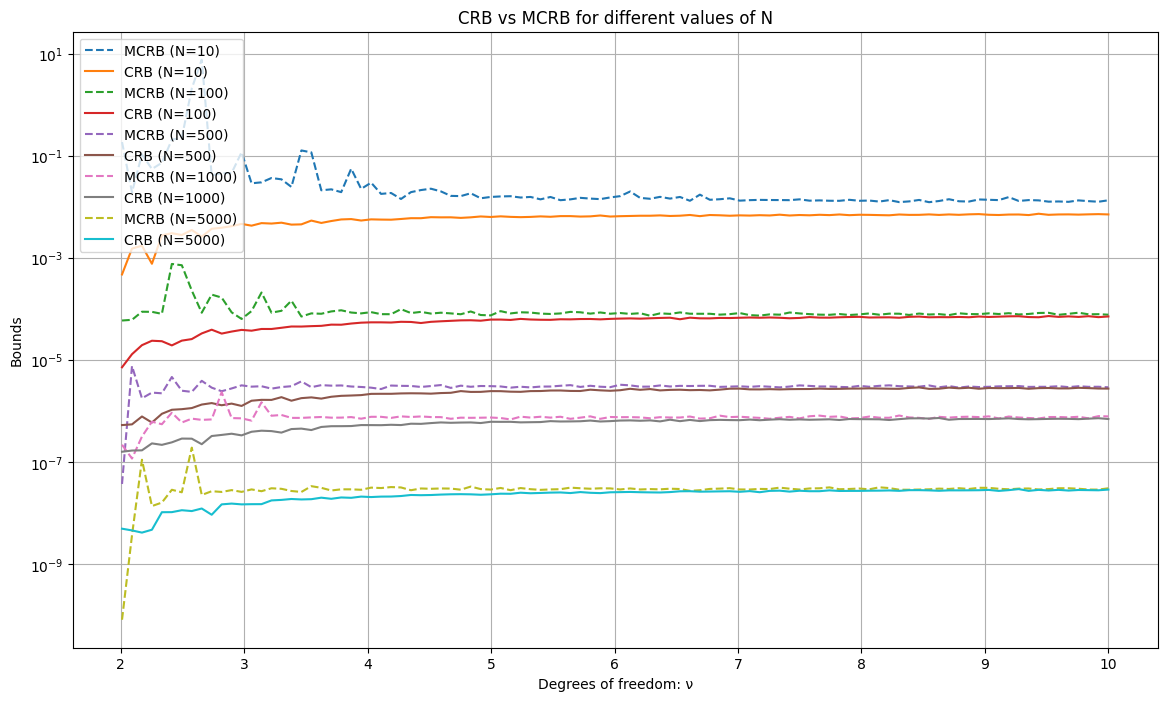

In [15]:
list_v = np.linspace(2.01, 10, 100)
list_N = [10, 100, 500, 1000, 5000]

plt.figure(figsize=(14, 8))

for n in list_N:
    list_MCRB = [compute_MCRB(v, theta,n) for v in list_v]
    list_CRB = [compute_CRB(v, theta,n) for v in list_v]
    print("N vaut ",n, end="\n")
    plt.plot(list_v, list_MCRB, label=f"MCRB (N={n})", linestyle="--")
    plt.plot(list_v, list_CRB, label=f"CRB (N={n})")

plt.xlabel("Degrees of freedom: ν")
plt.ylabel("Bounds")
plt.yscale("log")
plt.title("CRB vs MCRB for different values of N")
plt.legend()
plt.grid(True)
plt.show()


**Newton method to estimate $\theta$**

In [16]:
def log_likelihood_gradient(theta, X, nu, sigma2):
    N = len(X) - 1
    grad = 0
    for i in range(N):
        Xi, Xi1 = X[i], X[i + 1]
        z = Xi1 - theta * Xi
        denom = 1 + (z**2) / (nu * sigma2)
        grad += Xi * z / denom
    return ((nu + 1) / (nu * sigma2) )* grad

def log_likelihood_hessian(theta, X, nu, sigma2):
    N = len(X) - 1
    hess = 0
    for i in range(N):
        Xi, Xi1 = X[i], X[i + 1]
        z = Xi1 - theta * Xi
        denom = (1 + (z**2) / (nu * sigma2)) ** 2
        num = Xi**2 * (z**2 - nu * sigma2)
        hess += num / denom
    return (nu + 1) / (nu**2 * sigma2**2) * hess

def newton_theta_ml(X, nu, sigma2, tol=1e-10, max_iter=1000):
    numerator = np.sum([X[i] * X[i + 1] for i in range(len(X) - 1)])
    denominator = np.sum([X[i]**2 for i in range(len(X) - 1)])
    theta = numerator / denominator
    theta_list = [theta]
    for _ in range(max_iter):
        grad = log_likelihood_gradient(theta_list[-1], X, nu, sigma2)
        hess = log_likelihood_hessian(theta_list[-1], X, nu, sigma2)
        if abs(hess) < 1e-10:
            print("Hessiann close to 0, break")
            break
        theta_new = theta_list[-1] - grad / hess
        theta_list.append(theta_new)
        """if abs(theta_new - theta_list[-1]) < tol:
            return theta_list"""

    return theta_list

In [17]:
# A reminder of our simulation parameters
N=1000
sigma = 1
theta = 0.6
v = 3
X_student = generate_Student(theta,N,sigma,v)[0]
sigma2=sigma**2
theta_newton = newton_theta_ml(X_student, v, sigma2, max_iter=10)
print(f"Estimation of θ_ML : {theta_newton[-1]:.6f}")

Estimation of θ_ML : 0.583527


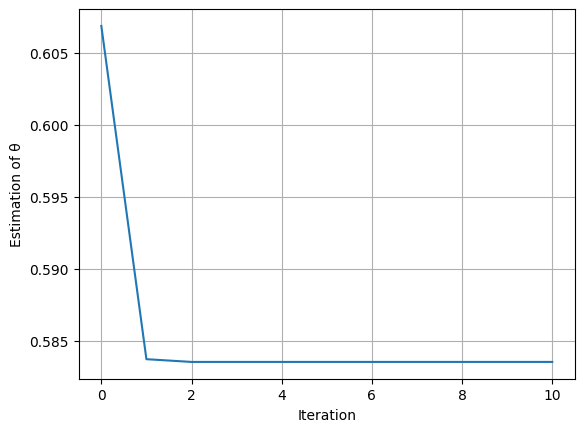

In [18]:
plt.plot(theta_newton)
plt.xlabel("Iteration")
plt.ylabel("Estimation of θ")
plt.grid(True)
plt.show()

In [19]:
# Compute the estimator
X_normal = generate_Normal(theta,N, sigma)[0]
def theta_ml_est(X, nu, sigma2):
    numerator = np.sum([X[i] * X[i + 1] for i in range(len(X) - 1)])
    denominator = np.sum([X[i]**2 for i in range(len(X) - 1)])
    return numerator / denominator

theta_ml = theta_ml_est(X_normal, v, sigma2)
print(theta_ml)

0.6044224831849836


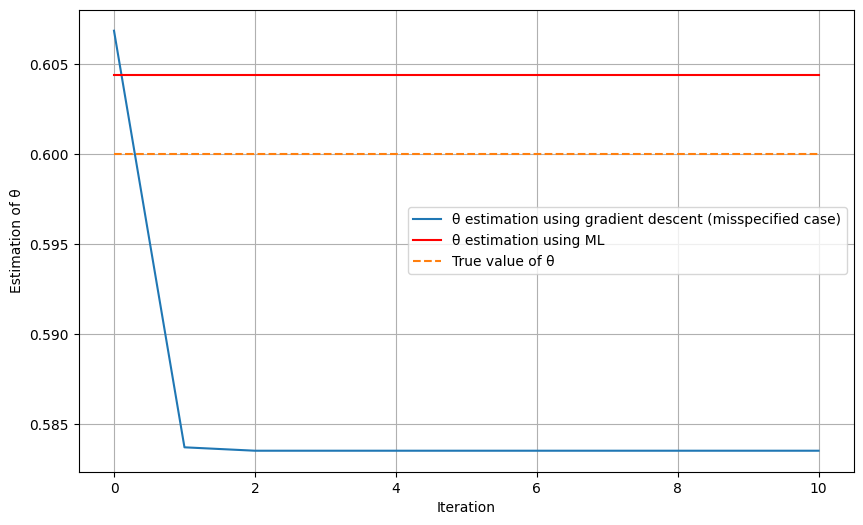

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(theta_newton, label="θ estimation using gradient descent (misspecified case)")
plt.plot([theta_ml] * len(theta_newton), label="θ estimation using ML",color='r')
plt.plot([theta] * len(theta_newton), label="True value of θ", linestyle="--")
plt.xlabel("Iteration")
plt.ylabel("Estimation of θ")
plt.grid(True)
plt.legend()
plt.show()

**Mean Square Error MSE($\hat{\theta}$)**

In [59]:
def square_error(theta_est,theta):
    return (theta_est - theta)**2

def mse_newton(N, v, sigma2):
    theta_newton_list = [newton_theta_ml(generate_Student(theta,N,sigma,v)[0], v, sigma2, max_iter=10)[-1] for _ in range(100)]
    square_error_list_newton = [square_error(theta_est,theta) for theta_est in theta_newton_list]
    mean_square_error_newton = np.mean(square_error_list_newton)
    return np.mean(mean_square_error_newton)

def mse_ml(N, v, sigma2):
    theta_ml_list = [theta_ml_est(generate_Normal(theta,N,sigma)[0], v, sigma2) for _ in range(100)]
    square_error_list_ml = [square_error(theta_ml,theta) for theta_ml in theta_ml_list]
    mean_square_error_ml = np.mean(square_error_list_ml)
    return np.mean(mean_square_error_ml)

print("MSE(theta_newton) :", mse_newton(N,v,sigma2))
print("MSE(theta_ml) :", mse_ml(N,v,sigma2))

MSE(theta_newton) : 1428.1299312231667
MSE(theta_ml) : 0.048216513540460575


In [22]:
list_N = np.arange(100, 10000, 100)

mean_square_error_list_newton = []
mean_square_error_list_ml = []

for N in list_N:
    mean_square_error_list_newton.append(mse_newton(N,v,sigma2))
    mean_square_error_list_ml.append(mse_ml(N,v,sigma2))
    print(N,end=" ")

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 

In [92]:
list_N = np.array(list_N)
mse_newton_arr = np.array(mean_square_error_list_newton)
mse_ml_arr = np.array(mean_square_error_list_ml)

# Delete the two outliers
mask_outliers = (list_N != 3300) & (list_N != 5500)
list_N_filtered = list_N[mask_outliers]
mse_newton_filtered = mse_newton_arr[mask_outliers]
mse_ml_filtered = mse_ml_arr[mask_outliers]

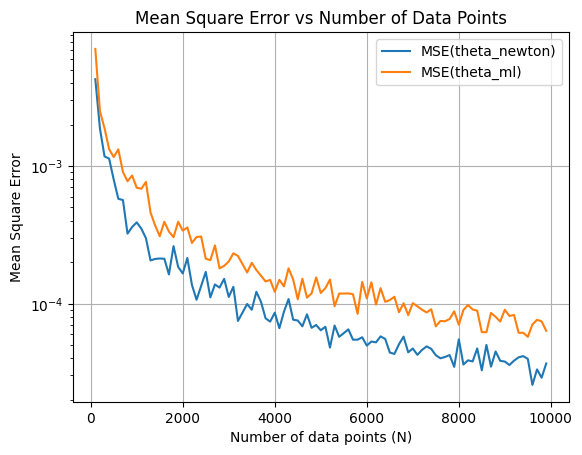

In [93]:
# Tracer
plt.plot(list_N_filtered, mse_newton_filtered, label="MSE(theta_newton)")
plt.plot(list_N_filtered, mse_ml_filtered, label="MSE(theta_ml)")
plt.xlabel("Number of data points (N)")
plt.ylabel("Mean Square Error")
plt.yscale("log")
plt.title("Mean Square Error vs Number of Data Points")
plt.legend()
plt.grid(True)
plt.show()

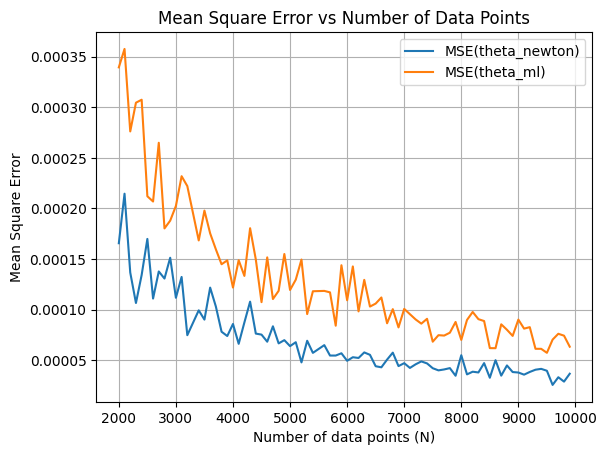

In [95]:
mask_min = list_N_filtered >= 2000
list_N_final = list_N_filtered[mask_min]
mse_newton_final = mse_newton_filtered[mask_min]
mse_ml_final = mse_ml_filtered[mask_min]

plt.plot(list_N_final, mse_newton_final, label="MSE(theta_newton)")
plt.plot(list_N_final, mse_ml_final, label="MSE(theta_ml)")
plt.xlabel("Number of data points (N)")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error vs Number of Data Points")
plt.legend()
plt.grid(True)
plt.show()

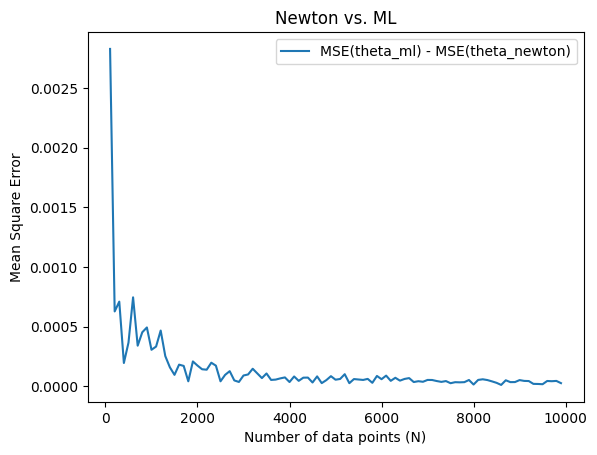

In [100]:
diff_mse_filtered = mse_ml_filtered - mse_newton_filtered

plt.plot(list_N_filtered, diff_mse_filtered, label="MSE(theta_ml) - MSE(theta_newton)")
plt.xlabel("Number of data points (N)")
plt.ylabel("Mean Square Error")
plt.title("Newton vs. ML")
plt.legend()